In [1]:
import os

import h5py

import matplotlib as mpl

def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 234.8775 # in pt.
width, height = set_size(width, fraction=0.8) # in inch
print(width, height)

fontsize = 9
mpl.rcParams.update({
    "figure.figsize": (width, height), 
    "figure.facecolor": 'white', 
    "figure.edgecolor": 'white',
    "savefig.dpi": 360, 
    "figure.subplot.bottom": 0.5, 
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": fontsize-2,
    "xtick.labelsize": fontsize-2,
    "ytick.labelsize": fontsize-2,
    # tight layout,
    "figure.autolayout": True,
})

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from scipy.ndimage import uniform_filter1d
from scipy.stats import rankdata

2.6 1.6068883707497268


## Loading The Data

In [2]:
from yahpo_gym import local_config
local_config.init_config()
local_config.set_data_path("/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/YAHPO/build/data/")

In [24]:
from yahpo_gym import *

scenario = "nb301"
yahpo_bench = BenchmarkSet(scenario=scenario, instance=1)
f_space = yahpo_bench.get_fidelity_space()
min_f, max_f = f_space["epoch"].lower, f_space["epoch"].upper
print(min_f, max_f)
# sample_yahpo_config = dict(yahpo_bench.get_opt_space(drop_fidelity_params=False).sample_configuration(1))

1 98


In [21]:
target = yahpo_bench.objective_function(sample_yahpo_config)
target

[{'val_accuracy': 91.80558, 'runtime': 4875.508}]

0it [00:00, ?it/s]

M.shape=(1000, 98)
R.shape=(1000, 98)


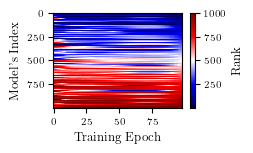

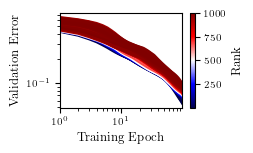

In [26]:
from copy import deepcopy


random_state = 42
rs = np.random.RandomState(random_state)
num_models = 1_000

selection = rs.choice(np.arange(num_models), size=num_models, replace=False)

sample_yahpo_config = dict(yahpo_bench.get_opt_space(drop_fidelity_params=True).sample_configuration(1))

def update_epoch(xs, epoch):
    tmp = deepcopy(xs)
    tmp.update({"epoch": epoch})
    return tmp

def build_curve(config, min_f, max_f):
    configs = [update_epoch(config, epoch_i) for epoch_i in range(min_f, max_f+1) ]
    targets = yahpo_bench.objective_function(configs)
    c = [(100-target_i["val_accuracy"])/100 for target_i in targets]
    return c

# def build_curve(config, min_f=2, max_f=51):
#     c = []
#     for epoch_i in range(min_f, max_f+1):
#         config.update({"epoch": epoch_i})
#         target = yahpo_bench.objective_function(config)
#         c.append(100-target[0]["val_accuracy"])
    # return c

M = []
for i, configid in tqdm(enumerate(selection)):

    config = dict(yahpo_bench.get_opt_space(drop_fidelity_params=True).sample_configuration(1))
    y = build_curve(config, min_f, max_f)
    y = np.asarray(y).reshape(1, -1)
    C = np.mean(y, axis=0).tolist()
    M.append(C)
M = np.asarray(M)
print(f"{M.shape=}")

# ranking matrix per step
R = rankdata(M, axis=0)
print(f"{R.shape=}")

idx_sorting = np.argsort(R[:,-1])

# Stability of Ranking
plt.figure()
plt.imshow(R[idx_sorting], cmap="seismic", interpolation="nearest", aspect="auto")
plt.colorbar(label="Rank")
plt.xlabel("Training Epoch")
plt.ylabel("Model's Index")
plt.tight_layout()
plt.savefig(f"yahpo-plots/heatmap_ranks_yahpo_{scenario}.png")
plt.show()

# Curves
cmap = mpl.colormaps["seismic"]

x = np.arange(min_f,max_f+1)
fig = plt.figure()
ax = plt.gca()

for i in range(M.shape[0]):
    plt.plot(x, M[idx_sorting][i], color=cmap(i/M.shape[0]))

plt.xscale("log")
plt.yscale("log")
plt.xlim(min_f,max_f)
plt.xlabel(r"Training Epoch")
plt.ylabel("Validation Error")
norm = mpl.cm.ScalarMappable(norm=None, cmap=cmap)
norm.set_clim(1, 1000)
cb = plt.colorbar(norm, ax=ax, label="Rank")
plt.tight_layout()
plt.savefig(f"yahpo-plots/ranking_curves_yahpo_{scenario}.png")
plt.show()

In [41]:
text = r"""
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/lcbench/curves/ranking_curves_yahpo_XXX.png}
        \caption{YYY}
        \label{fig:ranking-curves-yahpo-XXX}
    \end{subfigure}"""

text = r"""
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/yapho/curves/heatmap_ranks_yahpo_XXX.png}
        \caption{YYY}
        \label{fig:heatmap-yahpo-XXX}
    \end{subfigure}"""

In [42]:
for dataset in sorted(map_name2openmlid.keys()):
    print(text.replace("XXX", dataset).replace("YYY", dataset.replace("_", " ").replace("-", " ")), end="")


    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/yapho/curves/heatmap_ranks_yahpo_APSFailure.png}
        \caption{APSFailure}
        \label{fig:heatmap-yahpo-APSFailure}
    \end{subfigure}
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/yapho/curves/heatmap_ranks_yahpo_Amazon_employee_access.png}
        \caption{Amazon employee access}
        \label{fig:heatmap-yahpo-Amazon_employee_access}
    \end{subfigure}
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/yapho/curves/heatmap_ranks_yahpo_Australian.png}
        \caption{Australian}
        \label{fig:heatmap-yahpo-Australian}
    \end{subfigure}
    \begin{subfigure}[b]{0.24\textwidth}
        \centering
        \includegraphics[width=\textwidth]{figures/yapho/curves/heatmap_ranks_yahpo_Fashion-MNIST.png}
        \caption{Fashion MNIST}
      

In [42]:
len(dataset_list)

35